In [1]:
import os
import re
import sys
import tarfile
from six.moves import urllib

def maybe_download_and_extract(
  dest_directory='data',
  data_url='http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'):
  
  """Download and extract the tarball from Alex's website."""
  dest_directory = dest_directory
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = data_url.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  extracted_dir_path = os.path.join(dest_directory, 'cifar-10-batches-bin')
  if not os.path.exists(extracted_dir_path):
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [2]:
DATA_DIR = 'data'
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
maybe_download_and_extract(DATA_DIR, DATA_URL)

>> Downloading cifar-10-binary.tar.gz 100.0%
Successfully downloaded cifar-10-binary.tar.gz 170052171 bytes.


In [3]:

import numpy as np
import matplotlib.pyplot as plt

def extract_data(index=0, filepath='data/cifar-10-batches-bin/data_batch_5.bin'):
  bytestream = open(filepath, mode='rb')

  label_bytes_length = 1
  image_bytes_length = (32 ** 2) * 3
  record_bytes_length = label_bytes_length + image_bytes_length

  bytestream.seek(record_bytes_length * index, 0)
  label_bytes = bytestream.read(label_bytes_length)
  image_bytes = bytestream.read(image_bytes_length)

  label = np.frombuffer(label_bytes, dtype=np.uint8)  
  image = np.frombuffer(image_bytes, dtype=np.uint8)
  
  image = np.reshape(image, [3, 32, 32])
  image = np.transpose(image, [1, 2, 0])
  image = image.astype(np.float32)
  
  result = {
    'image': image,
    'label': label,
  }
  bytestream.close()
  return result

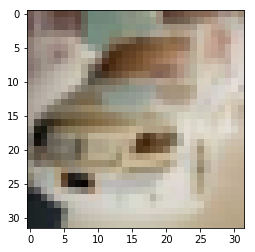

In [8]:
%matplotlib inline
result = extract_data(np.random.randint(1000))
plt.imshow(result['image'])

In [9]:
import math
import shutil
import tensorflow as tf

from datetime import datetime
from tensorflow.python.feature_column import feature_column

from tensorflow.contrib.learn import learn_runner
from tensorflow.contrib.learn import make_export_strategy

print(tf.__version__)

1.4.0


In [10]:

train_data_files = ['data/cifar-10-batches-bin/data_batch_{}.bin'.format(i) for i in range(1,5)]
valid_data_files = ['data/cifar-10-batches-bin/data_batch_5.bin']
test_data_files = ['data/cifar-10-batches-bin/test_batch.bin']

In [11]:
# Process images of this size. Note that this differs from the original CIFAR
# image size of 32 x 32. If one alters this number, then the entire model
# architecture will change and any model would need to be retrained.
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

# Global constants describing the CIFAR-10 data set.
NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

# If a model is trained with multiple GPUs, prefix all Op names with tower_name
# to differentiate the operations. Note that this prefix is removed from the
# names of the summaries when visualizing a model.
TOWER_NAME = 'tower'

# We use a weight decay of 0.0002, which performs better than the 0.0001 that
# was originally suggested.
WEIGHT_DECAY = 2e-4
MOMENTUM = 0.9

# Global constants describing model behaviors
MODEL_NAME = 'cnn-model-01'
USE_CHECKPOINT = False

In [15]:
def parse_record(raw_record):
    # Every record consists of a label followed by the image, with a fixed number
    # of bytes for each.
    label_bytes = 1
    image_bytes = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH
    record_bytes = label_bytes + image_bytes

    # Convert from a string to a vector of uint8 that is record_bytes long.
    record_vector = tf.decode_raw(raw_record, tf.uint8)

    # The first byte represents the label, which we convert from uint8 to int32
    # and then to one-hot.
    label = tf.cast(record_vector[0], tf.int32)
    label = tf.one_hot(label, NUM_CLASSES)

    # The remaining bytes after the label represent the image, which we reshape
    # from [depth * height * width] to [depth, height, width].
    depth_major = tf.reshape(
    record_vector[label_bytes:record_bytes], [IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])

    # Convert from [depth, height, width] to [height, width, depth], and cast as
    # float32.
    image = tf.cast(tf.transpose(depth_major, [1, 2, 0]), tf.float32)

    return image, label

In [17]:
def preprocess_image(image, is_training=False):
    """Preprocess a single image of layout [height, width, depth]."""
    if is_training:
    # Resize the image to add four extra pixels on each side.
        image = tf.image.resize_image_with_crop_or_pad(
        image, IMAGE_HEIGHT + 8, IMAGE_WIDTH + 8)

    # Randomly crop a [_HEIGHT, _WIDTH] section of the image.
    image = tf.random_crop(image, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])

    # Randomly flip the image horizontally.
    image = tf.image.random_flip_left_right(image)

    # Subtract off the mean and divide by the variance of the pixels.
    image = tf.image.per_image_standardization(image)
    return image

In [19]:
def generate_input_fn(file_names,
                      mode=tf.estimator.ModeKeys.EVAL,
                      batch_size=1):

    def _input_fn():
        label_bytes = 1
        image_bytes = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH
        record_bytes = label_bytes + image_bytes
        dataset = tf.data.FixedLengthRecordDataset(filenames=file_names,
                                                   record_bytes=record_bytes)

        is_training = (mode == tf.estimator.ModeKeys.TRAIN)
        if is_training:
            buffer_size = batch_size * 2 + 1
            dataset = dataset.shuffle(buffer_size=buffer_size)

        dataset = dataset.map(parse_record)
        dataset = dataset.map(lambda image, label: (preprocess_image(image, is_training), label))

        dataset = dataset.prefetch(2 * batch_size)

        # We call repeat after shuffling, rather than before, to prevent separate
        # epochs from blending together.
        dataset = dataset.repeat()

        # Batch results by up to batch_size, and then fetch the tuple from the
        # iterator.
        dataset = dataset.batch(batch_size)
        iterator = dataset.make_one_shot_iterator()
        images, labels = iterator.get_next()

        features = {'images': images}
        return features, labels

    return _input_fn

In [20]:
def get_feature_columns():
    feature_columns = {
    'images': tf.feature_column.numeric_column('images', (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)),
    }
    return feature_columns

In [21]:

feature_columns = get_feature_columns()
print("Feature Columns: {}".format(feature_columns))

Feature Columns: {'images': _NumericColumn(key='images', shape=(32, 32, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)}


In [23]:
def _activation_summary(x):
    """Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measures the sparsity of activations.
    Args:
    x: Tensor
    Returns:
    nothing
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
    tf.summary.histogram(tensor_name + '/activations', x)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

def _variable_on_cpu(name, shape, initializer):
    """Helper to create a Variable stored on CPU memory.
    Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable
    Returns:
    Variable Tensor
    """
    with tf.device('/cpu:0'):
        dtype = tf.float32
        var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
    return var

def _variable_with_weight_decay(name, shape, stddev, wd):
    """Helper to create an initialized Variable with weight decay.
    Note that the Variable is initialized with a truncated normal distribution.
    A weight decay is added only if one is specified.
    Args:
    name: name of the variable
    shape: list of ints
    stddev: standard deviation of a truncated Gaussian
    wd: add L2Loss weight decay multiplied by this float. If None, weight
        decay is not added for this Variable.
    Returns:
    Variable Tensor
    """
    dtype = tf.float32
    var = _variable_on_cpu(
      name,
      shape,
      tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [24]:
def inference(images):
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, 3, 64], stddev=5e-2, wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)
        _activation_summary(conv1)
    
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')

    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights', shape=[5, 5, 64, 64], stddev=5e-2, wd=0.0)
        conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name)
        _activation_summary(conv2)

    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')
    
    with tf.variable_scope('local3') as scope:
        pool2_shape = pool2.get_shape()
        dim = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]
        reshape = tf.reshape(pool2, [-1, dim])
        weights = _variable_with_weight_decay('weights', shape=[dim, 384], stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)
        _activation_summary(local3)

    with tf.variable_scope('local4') as scope:
        weights = _variable_with_weight_decay('weights', shape=[384, 192], stddev=0.04, wd=0.004)
        biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
        _activation_summary(local4)

    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [192, NUM_CLASSES], stddev=1/192.0, wd=0.0)
        biases = _variable_on_cpu('biases', [NUM_CLASSES], tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
        _activation_summary(logits)

    return logits

In [25]:

def get_loss(logits, labels):
    # Calculate loss, which includes softmax cross entropy and L2 regularization.
    cross_entropy = tf.losses.softmax_cross_entropy(
    logits=logits, onehot_labels=labels)

    # Create a tensor named cross_entropy for logging purposes.
    tf.identity(cross_entropy, name='cross_entropy')
    tf.summary.scalar('cross_entropy', cross_entropy)

    # Add weight decay to the loss.
    loss = cross_entropy + WEIGHT_DECAY * tf.add_n(
      [tf.nn.l2_loss(v) for v in tf.trainable_variables()])

    return loss

In [26]:
def get_train_op(loss, params, mode):
    if mode == tf.estimator.ModeKeys.TRAIN:
        # Scale the learning rate linearly with the batch size. When the batch size
        # is 128, the learning rate should be 0.1.
        initial_learning_rate = 0.1 * params.batch_size / 128
        batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / params.batch_size
        global_step = tf.train.get_or_create_global_step()

        # Multiply the learning rate by 0.1 at 100, 150, and 200 epochs.
        boundaries = [int(batches_per_epoch * epoch) for epoch in [100, 150, 200]]
        values = [initial_learning_rate * decay for decay in [1, 0.1, 0.01, 0.001]]
        learning_rate = tf.train.piecewise_constant(
            tf.cast(global_step, tf.int32), boundaries, values)

        # Create a tensor named learning_rate for logging purposes
        tf.identity(learning_rate, name='learning_rate')
        tf.summary.scalar('learning_rate', learning_rate)

        optimizer = tf.train.MomentumOptimizer(
            learning_rate=learning_rate,
            momentum=MOMENTUM)

        # Batch norm requires update ops to be added as a dependency to the train_op
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step)
    else:
        train_op = None

    return train_op

In [27]:
def get_metrics(predictions, labels):
    # Calculate accuracy
    accuracy = tf.metrics.accuracy(predictions['classes'],
                                 tf.argmax(labels, axis=1))

    # Create a tensor named train_accuracy for logging purposes
    tf.identity(accuracy[1], name='train_accuracy')
    tf.summary.scalar('train_accuracy', accuracy[1])

    return {'accuracy': accuracy}

In [35]:
def model_fn(features, labels, mode, params):
    # Create the input layers from the features
    feature_columns = list(get_feature_columns().values())

    images = tf.feature_column.input_layer(
    features=features, feature_columns=feature_columns)

    images = tf.reshape(
    images, shape=(-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

    # Calculate logits through CNN
    logits = inference(images)

    # Get predictions
    predictions = {
    'classes': tf.argmax(logits, axis=1),
    'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }

    # Provide an estimator spec for `ModeKeys.PREDICT`
    if mode == tf.estimator.ModeKeys.PREDICT:
        export_outputs = {
          'predictions': tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      export_outputs=export_outputs)

    loss = get_loss(logits=logits, labels=labels)
    train_op = get_train_op(loss=loss, mode=mode, params=params)
    metrics = get_metrics(predictions=predictions, labels=labels)

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
    mode=mode,
    predictions=predictions,
    loss=loss,
    train_op=train_op,
    eval_metric_ops=metrics)

In [36]:
def create_estimator(run_config, hparams):
    return tf.estimator.Estimator(
      model_fn=model_fn,
      params=hparams,
      config=run_config)

In [45]:
hparams = tf.contrib.training.HParams(
  batch_size=200,
  max_steps=100000,
)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.contrib.learn.RunConfig(
  save_checkpoints_steps=100,
  tf_random_seed=19851211,
  model_dir=model_dir
)

In [47]:
estimator = create_estimator(run_config, hparams)

train_spec = tf.estimator.TrainSpec(
  input_fn=generate_input_fn(file_names=train_data_files,
                             mode=tf.contrib.learn.ModeKeys.TRAIN,
                             batch_size=hparams.batch_size),
  max_steps=hparams.max_steps,
  hooks=None
)

eval_spec = tf.estimator.EvalSpec(
  input_fn=generate_input_fn(file_names=valid_data_files,
                             mode=tf.contrib.learn.ModeKeys.EVAL,
                             batch_size=hparams.batch_size),
  steps=50,
  name=None,
  hooks=None,
  start_delay_secs=120,
  throttle_secs=600
)

INFO:tensorflow:Using config: {'_environment': 'local', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_evaluation_master': '', '_model_dir': 'trained_models/cnn-model-01', '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_num_worker_replicas': 0, '_num_ps_replicas': 0, '_save_checkpoints_secs': None, '_tf_random_seed': 19851211, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D1633113C8>, '_master': '', '_task_type': None, '_log_step_count_steps': 100, '_is_chief': True, '_session_config': None}


In [48]:
if not USE_CHECKPOINT:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Removing previous artifacts...
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:step = 1, loss = 2.53161
INFO:tensorflow:Saving checkpoints for 101 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.1991
INFO:tensorflow:step = 101, loss = 2.82478 (7.040 sec)
INFO:tensorflow:Saving checkpoints for 201 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.3742
INFO:tensorflow:step = 201, loss = 2.79661 (6.963 sec)
INFO:tensorflow:Saving checkpoints for 301 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.6083
INFO:tensorflow:step = 301, loss = 2.76467 (6.852 sec)
INFO:tensorflow:Saving checkpoint

INFO:tensorflow:Saving checkpoints for 4301 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.9506
INFO:tensorflow:step = 4301, loss = 1.87105 (6.688 sec)
INFO:tensorflow:Saving checkpoints for 4401 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 15.0598
INFO:tensorflow:step = 4401, loss = 1.41967 (6.630 sec)
INFO:tensorflow:Saving checkpoints for 4501 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.7812
INFO:tensorflow:step = 4501, loss = 1.85558 (6.769 sec)
INFO:tensorflow:Saving checkpoints for 4601 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.7117
INFO:tensorflow:step = 4601, loss = 1.71622 (6.803 sec)
INFO:tensorflow:Saving checkpoints for 4701 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.9184
INFO:tensorflow:step = 4701, loss = 1.96739 (6.697 sec)
INFO:tensorflow:Saving checkpoints for 4801 into trained_models/cnn-mo

INFO:tensorflow:global_step/sec: 14.8544
INFO:tensorflow:step = 8701, loss = 2.02931 (6.738 sec)
INFO:tensorflow:Saving checkpoints for 8766 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:Loss for final step: 1.97516.
INFO:tensorflow:Starting evaluation at 2018-01-14-15:57:50
INFO:tensorflow:Restoring parameters from trained_models/cnn-model-01\model.ckpt-8766
INFO:tensorflow:Evaluation [1/50]
INFO:tensorflow:Evaluation [2/50]
INFO:tensorflow:Evaluation [3/50]
INFO:tensorflow:Evaluation [4/50]
INFO:tensorflow:Evaluation [5/50]
INFO:tensorflow:Evaluation [6/50]
INFO:tensorflow:Evaluation [7/50]
INFO:tensorflow:Evaluation [8/50]
INFO:tensorflow:Evaluation [9/50]
INFO:tensorflow:Evaluation [10/50]
INFO:tensorflow:Evaluation [11/50]
INFO:tensorflow:Evaluation [12/50]
INFO:tensorflow:Evaluation [13/50]
INFO:tensorflow:Evaluation [14/50]
INFO:tensorflow:Evaluation [15/50]
INFO:tensorflow:Evaluation [16/50]
INFO:tensorflow:Evaluation [17/50]
INFO:tensorflow:Evaluation [18/50]
IN

INFO:tensorflow:global_step/sec: 14.9173
INFO:tensorflow:step = 11867, loss = 1.71916 (6.711 sec)
INFO:tensorflow:Saving checkpoints for 11967 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.8974
INFO:tensorflow:step = 11967, loss = 1.69115 (6.708 sec)
INFO:tensorflow:Saving checkpoints for 12067 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.7328
INFO:tensorflow:step = 12067, loss = 1.79292 (6.777 sec)
INFO:tensorflow:Saving checkpoints for 12167 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.6244
INFO:tensorflow:step = 12167, loss = 1.76884 (6.845 sec)
INFO:tensorflow:Saving checkpoints for 12267 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.813
INFO:tensorflow:step = 12267, loss = 1.77488 (6.760 sec)
INFO:tensorflow:Saving checkpoints for 12367 into trained_models/cnn-model-01\model.ckpt.
INFO:tensorflow:global_step/sec: 14.9179
INFO:tensorflow:step

KeyboardInterrupt: 